# Note
This version might be slightly outdated in some areas compared to SMOTE version. The train/test index choice and methodology however are the same.

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import warnings
import random
SEED = 42  # Set to None for randomness
if SEED:
    random.seed(SEED)
    print(f"INFO: Using seed {SEED}")
else:
    print(f"Using random seed")

# Manual train/test splitting
warnings.filterwarnings('ignore')

INFO: Using seed 42


In [2]:
DATASET_DIRECTORY = '../CICIoT2023/'

### Importing Dataset

In [3]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
test_indexes_count = int(len(df_sets)*0.2)//4
train_indexes_count = int(len(df_sets)*0.8)//4
index_range = range(len(df_sets))
test_indexes = random.sample(index_range, test_indexes_count)
train_indexes = [i for i in index_range if i not in test_indexes][:train_indexes_count]
training_sets, test_sets = [], []
for i in train_indexes:
    training_sets.append(df_sets[i])
for i in test_indexes:
    test_sets.append(df_sets[i])
# training_sets = df_sets[:int(len(df_sets)*.8)]
# test_sets = df_sets[int(len(df_sets)*.8):]

In [4]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

### Scaling

In [5]:
from sklearn.preprocessing import StandardScaler
import joblib
scaler = StandardScaler()

In [6]:
scaler_filename = f"precomputed/scaler-{SEED}.save"

if os.path.exists(scaler_filename) and SEED is not None:
    scaler = joblib.load(scaler_filename) 
else:
    scaler = StandardScaler()
    for train_set in tqdm(train_indexes):
        scaler.fit(pd.read_csv(DATASET_DIRECTORY + '/' + df_sets[train_set])[X_columns])
    if SEED is not None:
        joblib.dump(scaler, scaler_filename)

### Classification: 34 (33+1) classes

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import f1_score

ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            eval_metric=f1_score,
            random_state=SEED,
            device='cuda'
        ),
        
]

ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'Xtra Gradient Boost'
]
label_encoder = LabelEncoder()
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            d[y_column] = label_encoder.fit_transform(d[y_column])
        print(f"Currently training {ML_neams[i]}")
        model.fit(d[X_columns], d[y_column])
    del d

  0%|          | 0/33 [00:00<?, ?it/s]

Currently training LogisticRegresion
Currently training Decision Tree
Currently training Random Forest
Currently training Xtra Gradient Boost
Currently training LogisticRegresion
Currently training Decision Tree
Currently training Random Forest
Currently training Xtra Gradient Boost
Currently training LogisticRegresion
Currently training Decision Tree
Currently training Random Forest
Currently training Xtra Gradient Boost
Currently training LogisticRegresion
Currently training Decision Tree
Currently training Random Forest
Currently training Xtra Gradient Boost
Currently training LogisticRegresion
Currently training Decision Tree
Currently training Random Forest
Currently training Xtra Gradient Boost
Currently training LogisticRegresion
Currently training Decision Tree
Currently training Random Forest
Currently training Xtra Gradient Boost
Currently training LogisticRegresion
Currently training Decision Tree
Currently training Random Forest
Currently training Xtra Gradient Boost
Curren

In [10]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

  0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("### 34 CLASSES ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    # plt.figure(figsize=(12, 9))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title('Confusion Matrix')
    # plt.savefig('confusion_matrix_seaborn.png', dpi=500, bbox_inches='tight')
    # plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-{SEED}/confusion_matrix-{ML_neams[k]}-34.csv')

print('\n\n')

### 34 CLASSES ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.8007950122384568;0.5870646945632153;0.48234706435050917;0.4872908021690314
WEIGHTED;LogisticRegresion;0.8007950122384568;0.8007950122384568;0.9124821629649549;0.8359222773306865
MACRO;Decision Tree;0.992626595126542;0.8193498824532404;0.8319775959007705;0.8243954144159964
WEIGHTED;Decision Tree;0.992626595126542;0.992626595126542;0.9925531022359825;0.9925815936928706
MACRO;Random Forest;0.992484040610272;0.8512658091088451;0.718051556781237;0.7288997470611169
WEIGHTED;Random Forest;0.992484040610272;0.992484040610272;0.9941423239566427;0.9930710614443533
MACRO;Xtra Gradient Boost;0.9924537098621294;0.7943690939123007;0.7261012650420969;0.7403318510920892
WEIGHTED;Xtra Gradient Boost;0.9924537098621294;0.9924537098621294;0.9934646580562401;0.9928739184856582




# Classification: 8 (7+1) classes

In [12]:
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            n_estimators=100,
            max_depth=10,
            learning_rate=0.1,
            random_state=SEED,
            device='cuda'
        ),
        
]

ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'Xtra Gradient Boost'
]
label_encoder = LabelEncoder()
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_7classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            d[y_column] = label_encoder.fit_transform(d[y_column])
        model.fit(d[X_columns], d[y_column])
    del d

  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_7classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

### 8 classes ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.8312405839275633;0.7578067549275618;0.5117799995417787;0.5396010685943926
WEIGHTED;LogisticRegresion;0.8312405839275633;0.8312405839275633;0.9516306757420755;0.8777887572179727


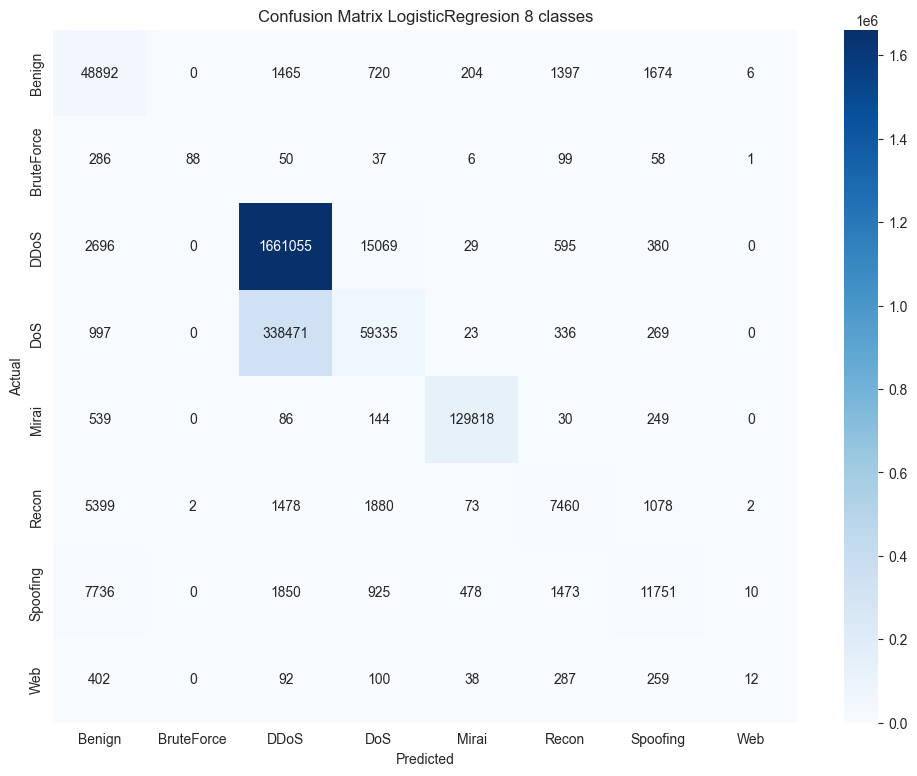

MACRO;Decision Tree;0.9943966109288618;0.8216846895111679;0.8365094431618119;0.8284455566600983
WEIGHTED;Decision Tree;0.9943966109288618;0.9943966109288618;0.9943717614591069;0.994380639263682


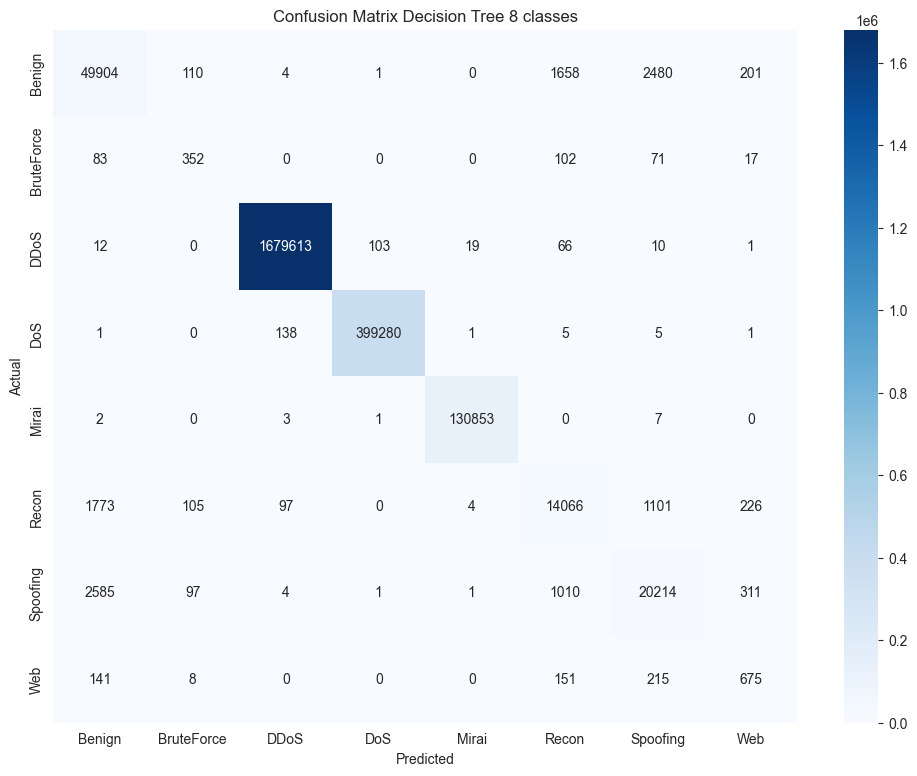

MACRO;Random Forest;0.9949239326501405;0.9337527059507711;0.7163071405099359;0.7353517638368883
WEIGHTED;Random Forest;0.9949239326501405;0.9949239326501405;0.9957956836537726;0.9952802261138534


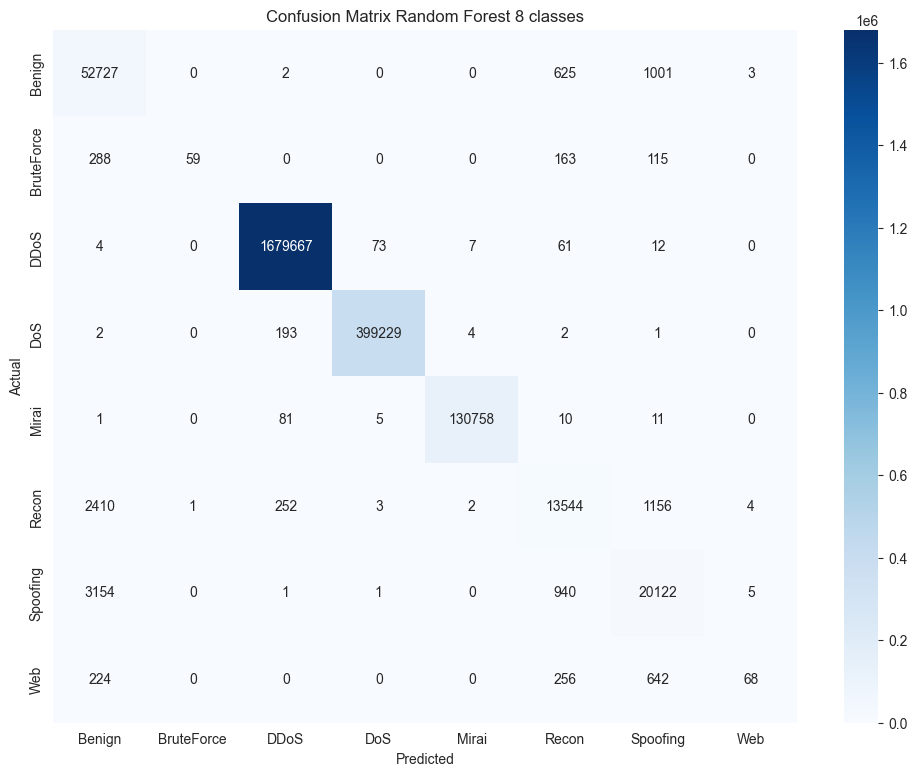

MACRO;Xtra Gradient Boost;0.9946773869973816;0.8376674641879751;0.7303903179085145;0.7521245984984313
WEIGHTED;Xtra Gradient Boost;0.9946773869973816;0.9946773869973816;0.9953121739481249;0.9949438704777844


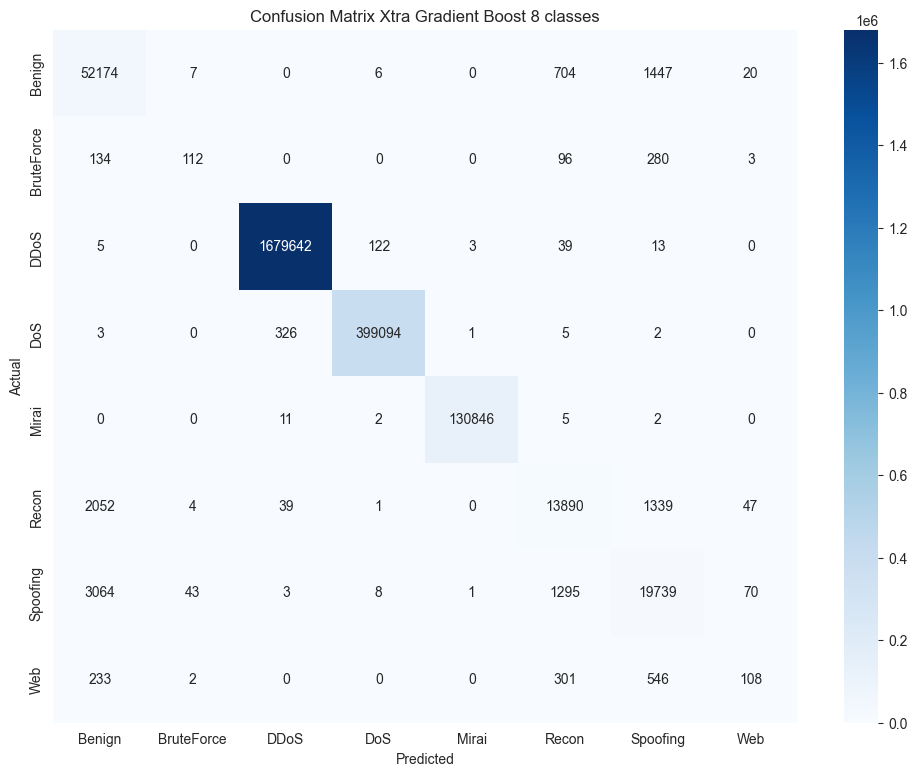

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("### 8 classes ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {ML_neams[k]} 8 classes')
    plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-{SEED}/confusion_matrix-{ML_neams[k]}-8.csv')

print('\n\n')

# Classification: 2 (1+1) Classes

In [ ]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'

dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            n_estimators=100,
            max_depth=10,
            learning_rate=0.1,
            random_state=SEED,
            device='cuda'
        ),
        
]

ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'Xtra Gradient Boost'
]
label_encoder = LabelEncoder()
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_2classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            d[y_column] = label_encoder.fit_transform(d[y_column])
        model.fit(d[X_columns], d[y_column])
    del d

In [ ]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

### 2 classes ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.9890791974830678;0.8910038249094818;0.8641423113625777;0.8770682698269014
WEIGHTED;LogisticRegresion;0.9890791974830678;0.9890791974830678;0.9895132323725289;0.9892734249470891


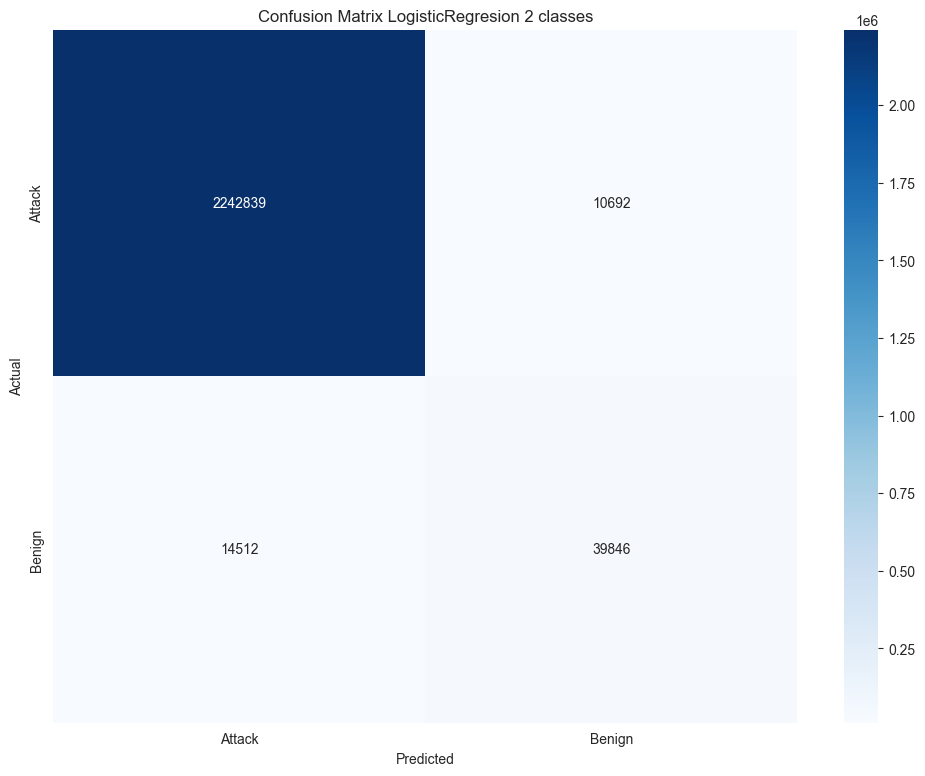

MACRO;Decision Tree;0.9959642773114304;0.9558052396236878;0.9565253134009262;0.9561649772468297
WEIGHTED;Decision Tree;0.9959642773114304;0.9959642773114304;0.9959611210078343;0.9959626846770367


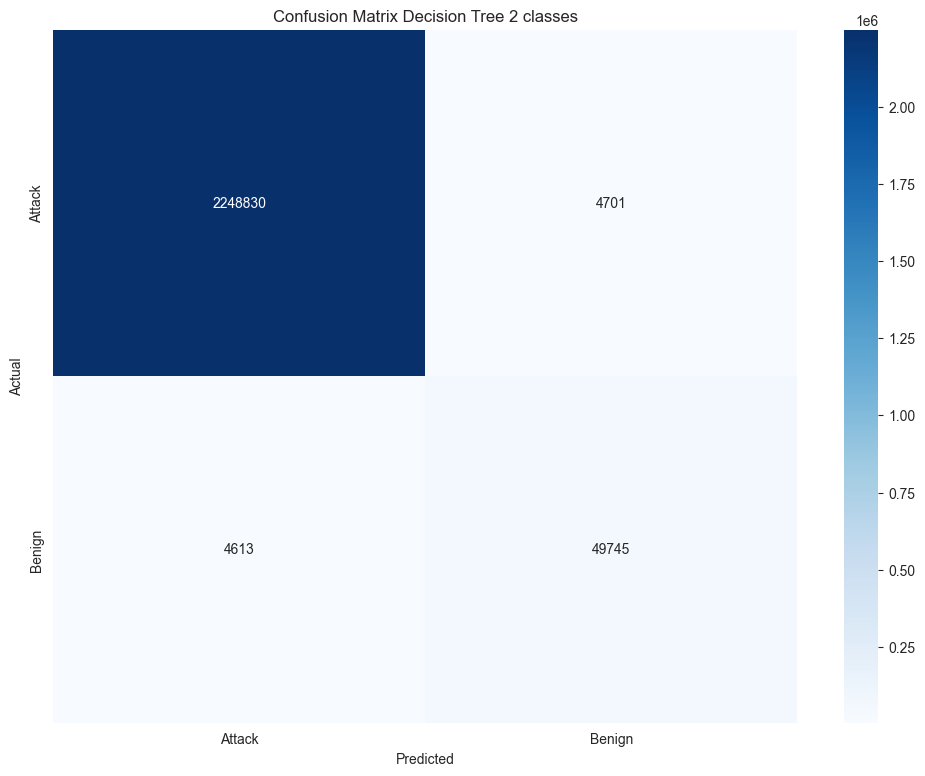

MACRO;Random Forest;0.9970397189812855;0.9653251096475803;0.9707201389009412;0.9680062570841326
WEIGHTED;Random Forest;0.9970397189812855;0.9970397189812855;0.9970242563971851;0.9970311879892233


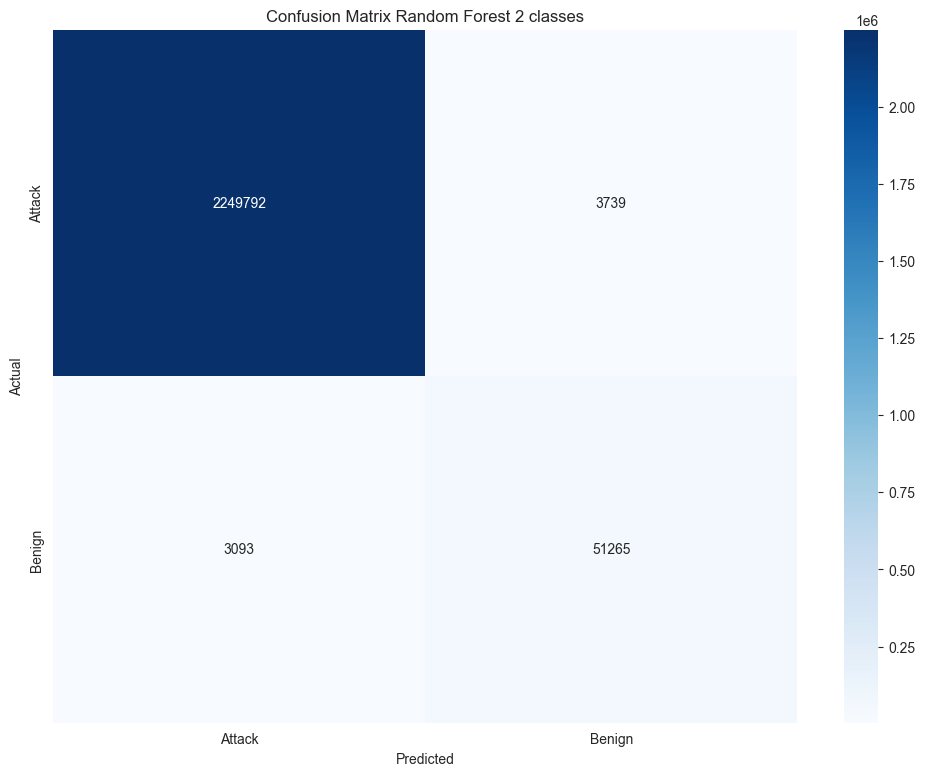

MACRO;Xtra Gradient Boost;0.9968070388133918;0.9590384202945128;0.9727822587331773;0.9658035729645688
WEIGHTED;Xtra Gradient Boost;0.9968070388133918;0.9968070388133918;0.9967705729619523;0.9967834917415769


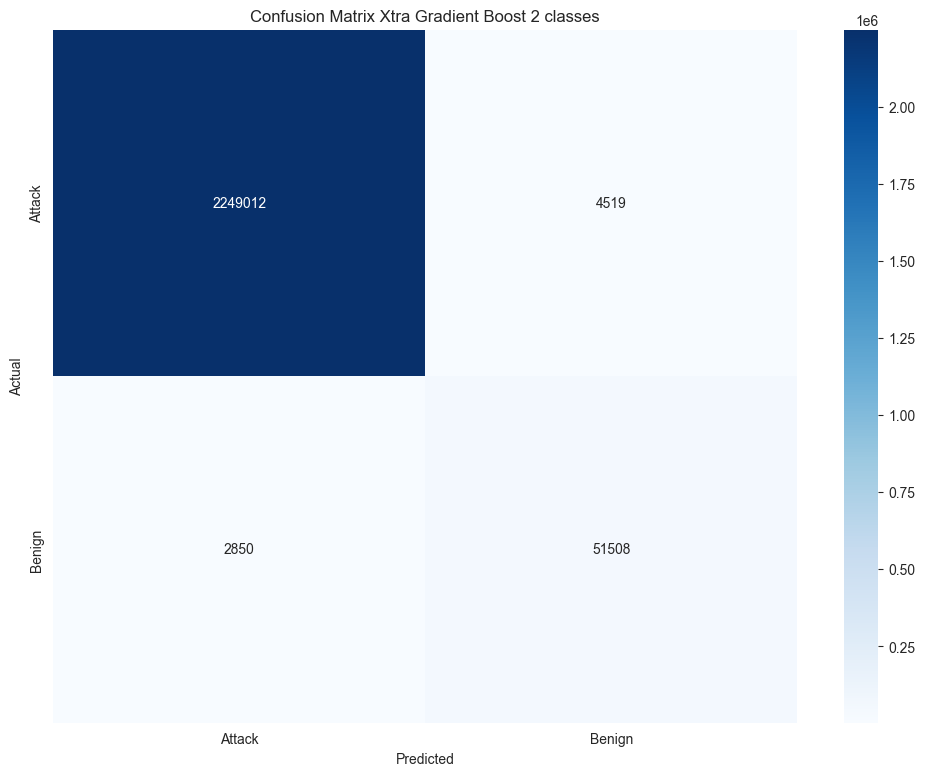

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("### 2 classes ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {ML_neams[k]} 2 classes')
    plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-{SEED}/confusion_matrix-{ML_neams[k]}-2.csv')

print('\n\n')